
# Lesson 2 — Practical Setup & First Run (Hands-on Notebook)

This notebook gives a **small, runnable demo** of the key ideas from Lesson 2, in order:

1. **Choose a starting point**: checkpoint vs scratch  
2. **Tokenizer alignment**: special tokens, PAD mask, unknown-token rate  
3. **Context length & truncation rules**  
4. **Learning-rate schedule & effective batch size (EBS)**  
5. **Evaluation & monitoring from day 1**  
6. **Token budget & data mix** (simple planning math)  
7. **Cost & run plan sanity check**  
8. **Pre-flight checklist** (batch preview + config snapshot)  
9. **Smoke test** (200–500 steps)  
10. **Common “uh-ohs” & quick fixes**

> **Note:** We’ll use a **tiny causal LM** for speed. Replace configs / model names with your own when running on real data.



## 0) Setup
Install libraries (skip if already installed) and import.


In [1]:

# If needed, uncomment to install
# !pip install -q torch transformers datasets accelerate matplotlib

import math, time, json, random, os
from dataclasses import dataclass
from typing import List, Dict, Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoConfig, AutoModelForCausalLM, AutoTokenizer,
    GPT2Config, GPT2LMHeadModel, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,3.5)  # modest size for classroom
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'


## 1) Choose a starting point: checkpoint vs scratch

- **Checkpoint:** load a small pretrained model (e.g., `distilgpt2`)  
- **Scratch:** create a **tiny** GPT-2 config and initialize random weights


In [2]:

# A) From checkpoint (good default for most work)
ckpt_name = "distilgpt2"  # small and fast
tok_ckpt = AutoTokenizer.from_pretrained(ckpt_name)
model_ckpt = AutoModelForCausalLM.from_pretrained(ckpt_name).to(device)
sum(p.numel() for p in model_ckpt.parameters())/1e6


81.912576

In [3]:

# B) From scratch (only when you truly need to)
scratch_cfg = GPT2Config(
    n_layer=2, n_head=2, n_embd=128, n_positions=512, n_ctx=512, vocab_size=len(tok_ckpt)
)
model_scratch = GPT2LMHeadModel(scratch_cfg).to(device)
sum(p.numel() for p in model_scratch.parameters())/1e6


6.895232


> **Takeaway:** prefer a **checkpoint** unless you have a strong reason to start from scratch.



## 2) Tokenizer alignment: special tokens, PAD mask, unknown-token rate
We’ll make sure the **tokenizer matches** the model, **special tokens** are defined, and the **PAD** positions are **ignored by loss**.


In [4]:

# Ensure EOS/PAD are set
# Many GPT2-like tokenizers have eos_token but no pad_token; set pad_token to eos or a new token for batching
if tok_ckpt.pad_token is None:
    tok_ckpt.pad_token = tok_ckpt.eos_token

print("EOS:", tok_ckpt.eos_token, tok_ckpt.eos_token_id)
print("PAD:", tok_ckpt.pad_token, tok_ckpt.pad_token_id)


EOS: <|endoftext|> 50256
PAD: <|endoftext|> 50256


In [5]:

# Unknown-token rate on a sample batch
sample_texts = [
    "Hello world! This is a quick tokenizer check.",
    "C'est la vie — naïve façade coöperate. 日本語テスト。",
    "ACME v2.1 released: http://example.com/docs?id=12345"
]
enc = tok_ckpt(sample_texts, padding=True, truncation=True, max_length=64, return_tensors='pt')
unk_id = tok_ckpt.unk_token_id
if unk_id is None:
    print("Tokenizer has no explicit <unk>; using high-byte tokens for OOV handling.")
else:
    oov = (enc["input_ids"] == unk_id).float().mean().item()
    print(f"Unknown-token rate: {oov:.4f}")
for k, v in enc.items():
    print(k, v.shape)


Unknown-token rate: 0.2533
input_ids torch.Size([3, 25])
attention_mask torch.Size([3, 25])


In [6]:

# Show one row: token ids, attention mask, and where EOS appears
row = 0
ids = enc["input_ids"][row].tolist()
mask = enc["attention_mask"][row].tolist()
print("Token IDs:", ids[:40], "...")
print("Mask    :", mask[:40], "...")
# Confirm PADs:
pad_positions = [i for i, t in enumerate(ids) if t == tok_ckpt.pad_token_id]
print("PAD positions:", pad_positions[:10])


Token IDs: [15496, 995, 0, 770, 318, 257, 2068, 11241, 7509, 2198, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256] ...
Mask    : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ...
PAD positions: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



## 3) Context length & truncation rules (head/tail/balanced)
Pick the **smallest** max length that fits your tasks. Define a **consistent** truncation rule.


In [7]:

def truncate_head_tail(tokens: List[int], max_len: int, mode='head'):
    if len(tokens) <= max_len:
        return tokens
    if mode == 'head':      # keep the beginning
        return tokens[:max_len]
    if mode == 'tail':      # keep the end
        return tokens[-max_len:]
    # balanced: keep equal parts from start/end
    half = max_len // 2
    return tokens[:half] + tokens[-(max_len-half):]

long_sample = " ".join(["lorem_ipsum"]*200)
long_ids = tok_ckpt(long_sample, add_special_tokens=False)["input_ids"]
for rule in ['head','tail','balanced']:
    cut = truncate_head_tail(long_ids, max_len=32, mode=rule)
    print(rule, "len:", len(cut), "head:", cut[:5], "... tail:", cut[-5:])


head len: 32 head: [75, 29625, 62, 2419, 388] ... tail: [62, 2419, 388, 24044, 76]
tail len: 32 head: [2419, 388, 24044, 76, 62] ... tail: [24044, 76, 62, 2419, 388]
balanced len: 32 head: [75, 29625, 62, 2419, 388] ... tail: [24044, 76, 62, 2419, 388]



## 4) Learning-rate schedule & effective batch size (EBS)
- **Warmup**: ~1–3% of steps  
- **Decay**: cosine or linear  
- **EBS** = micro_batch × grad_accum × #GPUs


Effective Batch Size (EBS): 32


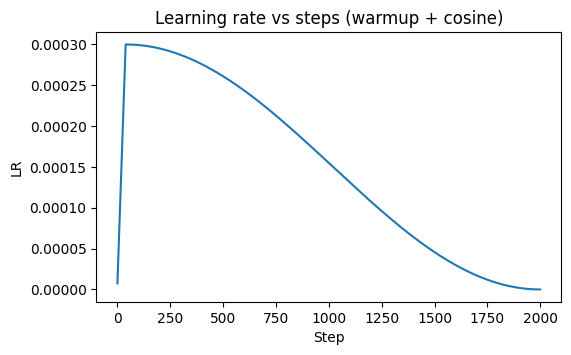

In [8]:

micro_batch = 8
grad_accum = 4
num_gpus = max(1, torch.cuda.device_count())
seq_len = 128

EBS = micro_batch * grad_accum * num_gpus
print("Effective Batch Size (EBS):", EBS)

total_steps = 2000
warmup_steps = int(0.02 * total_steps)  # 2% warmup
base_lr = 3e-4

# Simulate cosine schedule curve
lrs = []
for step in range(total_steps):
    if step < warmup_steps:
        lr = base_lr * (step + 1) / max(1, warmup_steps)
    else:
        progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
        lr = 0.5 * base_lr * (1 + math.cos(math.pi * progress))
    lrs.append(lr)

plt.plot(lrs)
plt.title("Learning rate vs steps (warmup + cosine)")
plt.xlabel("Step")
plt.ylabel("LR")
plt.show()



## 5) Evaluation & monitoring from day 1
We’ll set up a **tiny synthetic dataset**, a **dev set**, and log **loss**, **tokens/sec**, **LR**, and **memory** every few steps.


In [9]:

class ToyTextDataset(Dataset):
    def __init__(self, tokenizer, n_samples=1024, seq_len=128, vocab_prompt="Hello"):
        self.tok = tokenizer
        self.samples = [f"{vocab_prompt} sample {i}" for i in range(n_samples)]
        self.seq_len = seq_len
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        enc = self.tok(self.samples[idx], truncation=True, padding='max_length',
                       max_length=self.seq_len, return_tensors='pt')
        # Causal LM: labels are input_ids shifted by 1 inside the model
        return {k: v.squeeze(0) for k, v in enc.items()}

train_ds = ToyTextDataset(tok_ckpt, n_samples=512, seq_len=seq_len)
dev_ds = ToyTextDataset(tok_ckpt, n_samples=64, seq_len=seq_len, vocab_prompt="Eval")
train_loader = DataLoader(train_ds, batch_size=micro_batch, shuffle=True)
dev_loader = DataLoader(dev_ds, batch_size=micro_batch)

model = model_scratch  # small scratch model for demo speed
optim = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.01)

def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch, labels=batch["input_ids"])
            losses.append(out.loss.item())
    model.train()
    return sum(losses)/len(losses)

# quick dry run
model.train()
start = time.time()
log = {"step": [], "train_loss": [], "dev_loss": [], "tokens_sec": [], "lr": []}
warmup_steps = int(0.02 * total_steps)
for step, batch in enumerate(train_loader):
    if step > 50:  # short demo loop
        break
    batch = {k: v.to(device) for k, v in batch.items()}
    # simple warmup + cosine schedule
    if step < warmup_steps:
        lr = base_lr * (step + 1) / max(1, warmup_steps)
    else:
        progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
        lr = 0.5 * base_lr * (1 + math.cos(math.pi * progress))
    for g in optim.param_groups: g['lr'] = lr

    out = model(**batch, labels=batch["input_ids"])
    out.loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optim.step(); optim.zero_grad()

    # simple throughput estimate
    tokens_processed = batch["input_ids"].numel()
    elapsed = max(1e-6, time.time() - start)
    tps = tokens_processed / elapsed

    if step % 10 == 0:
        dev_l = eval_loss(model, dev_loader)
        log["step"].append(step)
        log["train_loss"].append(out.loss.item())
        log["dev_loss"].append(dev_l)
        log["tokens_sec"].append(tps)
        log["lr"].append(lr)
        print(f"step {step:4d} | train {out.loss.item():.3f} | dev {dev_l:.3f} | tps {tps:,.0f} | lr {lr: .2e}")
        start = time.time()  # reset window


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


step    0 | train 10.048 | dev 9.982 | tps 3,636 | lr  7.50e-06
step   10 | train 8.847 | dev 8.777 | tps 658 | lr  8.25e-05
step   20 | train 8.285 | dev 8.226 | tps 657 | lr  1.57e-04
step   30 | train 7.800 | dev 7.720 | tps 667 | lr  2.32e-04
step   40 | train 7.122 | dev 7.012 | tps 659 | lr  3.00e-04
step   50 | train 6.307 | dev 6.190 | tps 646 | lr  3.00e-04


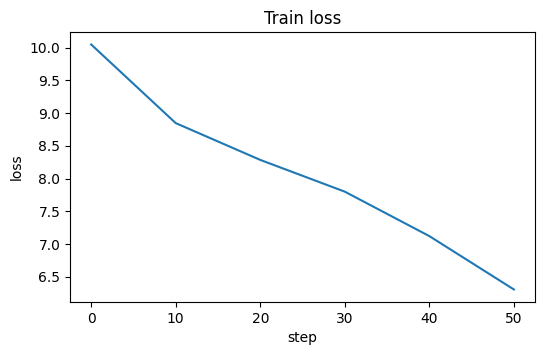

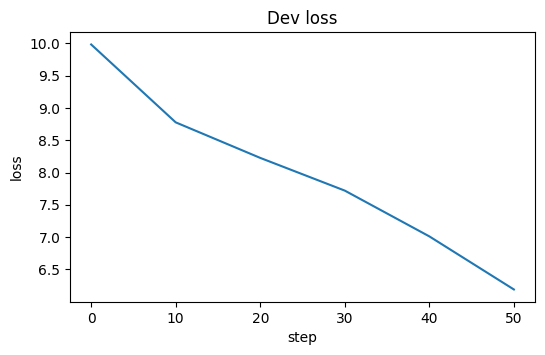

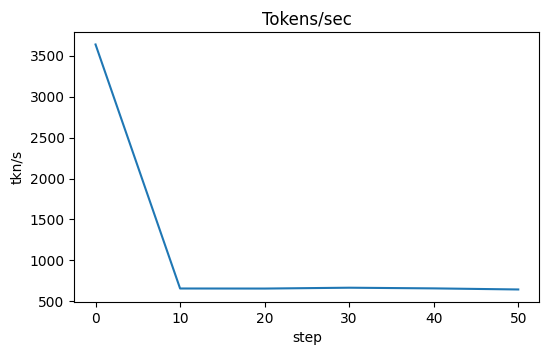

In [10]:

# Simple dashboard plots
fig, ax = plt.subplots()
ax.plot(log["step"], log["train_loss"]); ax.set_title("Train loss"); ax.set_xlabel("step"); ax.set_ylabel("loss")
plt.show()

fig, ax = plt.subplots()
ax.plot(log["step"], log["dev_loss"]); ax.set_title("Dev loss"); ax.set_xlabel("step"); ax.set_ylabel("loss")
plt.show()

fig, ax = plt.subplots()
ax.plot(log["step"], log["tokens_sec"]); ax.set_title("Tokens/sec"); ax.set_xlabel("step"); ax.set_ylabel("tkn/s")
plt.show()



## 6) Token budget & data mix (planning math)
Compute tokens per step, steps to target, and sketch a data mix.


In [11]:

def tokens_per_step(seq_len, ebs): return seq_len * ebs
def steps_from_goal(total_tokens, tps): return math.ceil(total_tokens / max(1, tps))

goal_tokens = 50_000_000  # 50M for demo
tps = tokens_per_step(seq_len, EBS)
steps_est = steps_from_goal(goal_tokens, tps)

print("tokens/step:", tps)
print("steps (to 50M):", steps_est)

data_mix = {
    "general": 0.60,
    "product_docs": 0.20,
    "support": 0.10,
    "code": 0.10,
}
data_mix


tokens/step: 4096
steps (to 50M): 12208


{'general': 0.6, 'product_docs': 0.2, 'support': 0.1, 'code': 0.1}


## 7) Cost & run plan sanity check
Estimate runtime, GPU-hours, and cost given **tokens/sec** and **#GPUs**.


In [12]:

def estimate_time_seconds(steps, tokens_step, tokens_sec):
    return (steps * tokens_step) / max(1e-9, tokens_sec)

def estimate_gpu_hours(seconds, num_gpus):
    return (seconds/3600.0) * num_gpus

def estimate_cost(gpu_hours, usd_per_gpu_hour):
    return gpu_hours * usd_per_gpu_hour

tokens_sec_measured = (log["tokens_sec"][-1]) if log["tokens_sec"] else 250000

steps_plan = 2000  # example plan
sec = estimate_time_seconds(steps_plan, tps, tokens_sec_measured)
gpu_hours = estimate_gpu_hours(sec, num_gpus)
usd = estimate_cost(gpu_hours, usd_per_gpu_hour=2.5)

print(f"Throughput used: {tokens_sec_measured:,.0f} tkn/s")
print(f"Runtime ~ {sec/3600:.2f} hr, GPU-hours ~ {gpu_hours:.2f}, Cost ~ ${usd:,.2f}")


Throughput used: 646 tkn/s
Runtime ~ 3.52 hr, GPU-hours ~ 3.52, Cost ~ $8.81



## 8) Pre-flight checklist (batch preview + config snapshot)
Quick validation before any long run.


In [13]:

def preview_batch(tokenizer, texts, max_length=128):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    row = 0
    ids = enc["input_ids"][row].tolist()
    mask = enc["attention_mask"][row].tolist()
    print("EOS id:", tokenizer.eos_token_id, "| PAD id:", tokenizer.pad_token_id)
    print("Token IDs (first 80):", ids[:80])
    print("Mask      (first 80):", mask[:80])
    return enc

def save_config_snapshot(path, config: dict):
    with open(path, "w") as f:
        json.dump(config, f, indent=2)
    return path

snapshot = {
    "model": ckpt_name,
    "start_mode": "scratch",  # or 'checkpoint'
    "seq_len": seq_len,
    "EBS": EBS,
    "base_lr": base_lr,
    "warmup_steps": warmup_steps,
    "dev_prompt": "Eval",
    "seed": 42,
    "truncation_rule": "balanced",
}

_ = preview_batch(tok_ckpt, ["Hello demo pre-flight batch!"], max_length=seq_len)
cfg_path = save_config_snapshot("preflight_config.json", snapshot)
print("Saved:", cfg_path)


EOS id: 50256 | PAD id: 50256
Token IDs (first 80): [15496, 13605, 662, 12, 22560, 15458, 0]
Mask      (first 80): [1, 1, 1, 1, 1, 1, 1]
Saved: preflight_config.json



## 9) Smoke test (200–500 steps)
Run a short test to confirm **stable loss** and healthy **throughput/memory** before a long run.


In [14]:

def run_smoke_test(model, tokenizer, train_ds, dev_ds, steps=200, lr=3e-4):
    model.train()
    loader = DataLoader(train_ds, batch_size=micro_batch, shuffle=True)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    warm = max(1, int(0.02*steps))
    start = time.time()
    stats = {"step": [], "train_loss": [], "dev_loss": [], "tps": []}
    i = 0
    while i < steps:
        for batch in loader:
            if i >= steps:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            # schedule
            if i < warm:
                cur_lr = lr * (i + 1) / warm
            else:
                progress = (i - warm) / max(1, (steps - warm))
                cur_lr = 0.5 * lr * (1 + math.cos(math.pi * progress))
            for g in optim.param_groups: g['lr'] = cur_lr

            out = model(**batch, labels=batch["input_ids"])
            out.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step(); optim.zero_grad()

            if i % 20 == 0:
                dev_l = eval_loss(model, DataLoader(dev_ds, batch_size=micro_batch))
                elapsed = max(1e-6, time.time() - start)
                tps = batch["input_ids"].numel() / elapsed
                stats["step"].append(i); stats["train_loss"].append(out.loss.item()); stats["dev_loss"].append(dev_l); stats["tps"].append(tps)
                print(f"[smoke] step {i:4d} | train {out.loss.item():.3f} | dev {dev_l:.3f} | tps {tps:,.0f}")
                start = time.time()
            i += 1
    return stats

# Example (short run)
# smoke_stats = run_smoke_test(model, tok_ckpt, train_ds, dev_ds, steps=60, lr=base_lr)
# smoke_stats
print("Ready to run: uncomment the call above to execute the smoke test.")


Ready to run: uncomment the call above to execute the smoke test.



## 10) Common “uh-ohs” & quick fixes
We simulate two fast failure modes and show how to detect/fix them.


In [15]:

# A) NaN/Inf from unmasked PAD (simulated)
def compute_loss_without_mask(model, batch):
    # BAD: ignore attention_mask and treat PAD as real tokens
    out = model(input_ids=batch["input_ids"].to(device), labels=batch["input_ids"].to(device))
    return out.loss

bad_batch = tok_ckpt(["This demo intentionally ignores masking"], padding=True, truncation=True, max_length=seq_len, return_tensors='pt')
try:
    loss_bad = compute_loss_without_mask(model, bad_batch)
    print("Loss computed (but masking ignored) => risk of NaN later if PAD dominates.")
except Exception as e:
    print("Error (as expected in some configs):", e)

# Fix: rely on attention_mask + ensure PAD is set and not learned
good_batch = tok_ckpt(["This demo uses proper masking"], padding=True, truncation=True, max_length=seq_len, return_tensors='pt')
with torch.no_grad():
    out_good = model(**{k: v.to(device) for k, v in good_batch.items()}, labels=good_batch["input_ids"].to(device))
    print("Good loss (mask respected):", float(out_good.loss))


Loss computed (but masking ignored) => risk of NaN later if PAD dominates.
Good loss (mask respected): 10.697732925415039


In [16]:

# B) LR too high (divergence)
def try_step_with_lr(model, loader, lr):
    model2 = model_scratch.to(device)  # fresh copy
    optim = torch.optim.AdamW(model2.parameters(), lr=lr)
    batch = next(iter(loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    losses = []
    for _ in range(10):
        out = model2(**batch, labels=batch["input_ids"])
        losses.append(float(out.loss))
        out.loss.backward()
        optim.step(); optim.zero_grad()
    return losses

loader = DataLoader(train_ds, batch_size=micro_batch, shuffle=True)
losses_ok = try_step_with_lr(model, loader, lr=3e-4)
losses_hi = try_step_with_lr(model, loader, lr=3e-2)  # intentionally high

print("OK LR (trend):", [round(x,3) for x in losses_ok[:5]], "...")
print("High LR (trend):", [round(x,3) for x in losses_hi[:5]], "... (likely unstable)")


OK LR (trend): [6.219, 6.175, 6.066, 5.996, 5.926] ...
High LR (trend): [5.457, 8.386, 0.131, 0.14, 0.155] ... (likely unstable)



### Where to go next
- Swap in your **real tokenizer and model checkpoint**.
- Point the dataset loader at your **real training data** and define a **dev set** you never train on.
- Expand the **smoke test** to 200–500 steps; only then launch a long run.
- Keep notes: config snapshots, seeds, data hashes, and evaluation cadence.
